# Prior SPDE + LSTM solver Evaluation Notebook (SPDE-based GP)

## 1. Import tools and change directory

In [5]:
from utils_GP import *
import pandas as pd
import os

In [6]:
os.chdir("/gpfswork/rech/yrf/uba22to/4dvarnet-core")
print(os.getcwd())

/gpfsdswork/projects/rech/yrf/uba22to/4dvarnet-core


## 2. Run the code 

In [7]:
!HYDRA_FULL_ERROR=1 python hydra_main.py xp=oi_gp_spde_learn_params file_paths=dc_gp entrypoint=run entrypoint.max_epochs=10

/gpfsdswork/projects/rech/yrf/uba22to/4dvarnet-core/hydra_main.py:212: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='hydra_config', config_name='main')
/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/upgrades/1.1_to_1.2/changes_to_job_working_dir for more information.
  ret = run_job(
Global seed set to 0
file_paths:
  obs_path: /gpfswork/rech/yrf/uba22to/4dvarnet-core/oi/data/SPDE_diffusion_dataset.nc
  gt_path: /gpfswork/rech/yrf/uba22to/4dvarnet-core/oi/data/SPDE_diffusion_dataset.nc
  spde_params_path: /gpfswork/rech/yrf/uba22to/4dvarnet-core/oi/data/SPDE_diffusion_dataset.nc
entrypoint:
  _target_: hydra_main.FourDVarNetHydraRunner.run
  max_epochs: 10
  progress_

Epoch 0:   0%|                                | 0/141 [00:00<00:00, 4373.62it/s]tensor(8.0183, device='cuda:0')
Error executing job with overrides: ['xp=oi_gp_spde_learn_params', 'file_paths=dc_gp', 'entrypoint=run', 'entrypoint.max_epochs=10']
Traceback (most recent call last):
  File "/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/hydra/_internal/instantiate/_instantiate2.py", line 92, in _call_target
    return _target_(*args, **kwargs)
  File "/gpfsdswork/projects/rech/yrf/uba22to/4dvarnet-core/hydra_main.py", line 87, in run
    mod, trainer = self.train(ckpt_path, **trainer_kwargs)
  File "/gpfsdswork/projects/rech/yrf/uba22to/4dvarnet-core/hydra_main.py", line 168, in train
    trainer.fit(mod, self.dataloaders['train'], self.dataloaders['val'])
  File "/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 552, in fit
    self._run(model)
  File "/linkhome/rech/genimt01/uba22

In [97]:
import glob
from datetime import datetime
import numpy as np

dirs = glob.glob("/gpfswork/rech/yrf/uba22to/4dvarnet-core/dashboard/oi_gp_spde_learn_params/lightning_logs/*")
file = max(dirs, key=os.path.getctime) + "/maps.nc"
print(file)

# import 4dvarNet reconstruction
data_4dvarnet = xr.open_dataset(file).isel(daw=2)
#time = [ np.datetime_as_string(date, unit='D') for date in data_4dvarnet.time.values ]
time = data_4dvarnet.Time.values

# import OI baseline
file = "/gpfswork/rech/yrf/uba22to/4dvarnet-core/oi/data/SPDE_diffusion_dataset.nc"
data_baseline = xr.open_dataset(file)
data_baseline['time'] = pd.date_range(start="2012-10-01", periods=data_baseline.sizes['time'], freq='D')
data_baseline = data_baseline.sel(time=slice(time[0],time[-1]))

# rename variables
data_baseline = data_baseline.update({
                     'gt':(('time','lat','lon'),data_4dvarnet.gt.values),
                     'obs_inp':(('time','lat','lon'),data_4dvarnet.obs.values),
                     'pred':(('time','lat','lon'),data_baseline.OI.values)})
data_4dvarnet = data_4dvarnet.update({
                     'obs_inp':(('time','lat','lon'),
                                np.where(data_4dvarnet.obs.values==np.median(data_4dvarnet.obs.values),np.nan,data_4dvarnet.obs.values))})

/gpfswork/rech/yrf/uba22to/4dvarnet-core/dashboard/oi_gp_spde_learn_params/lightning_logs/version_134/maps.nc


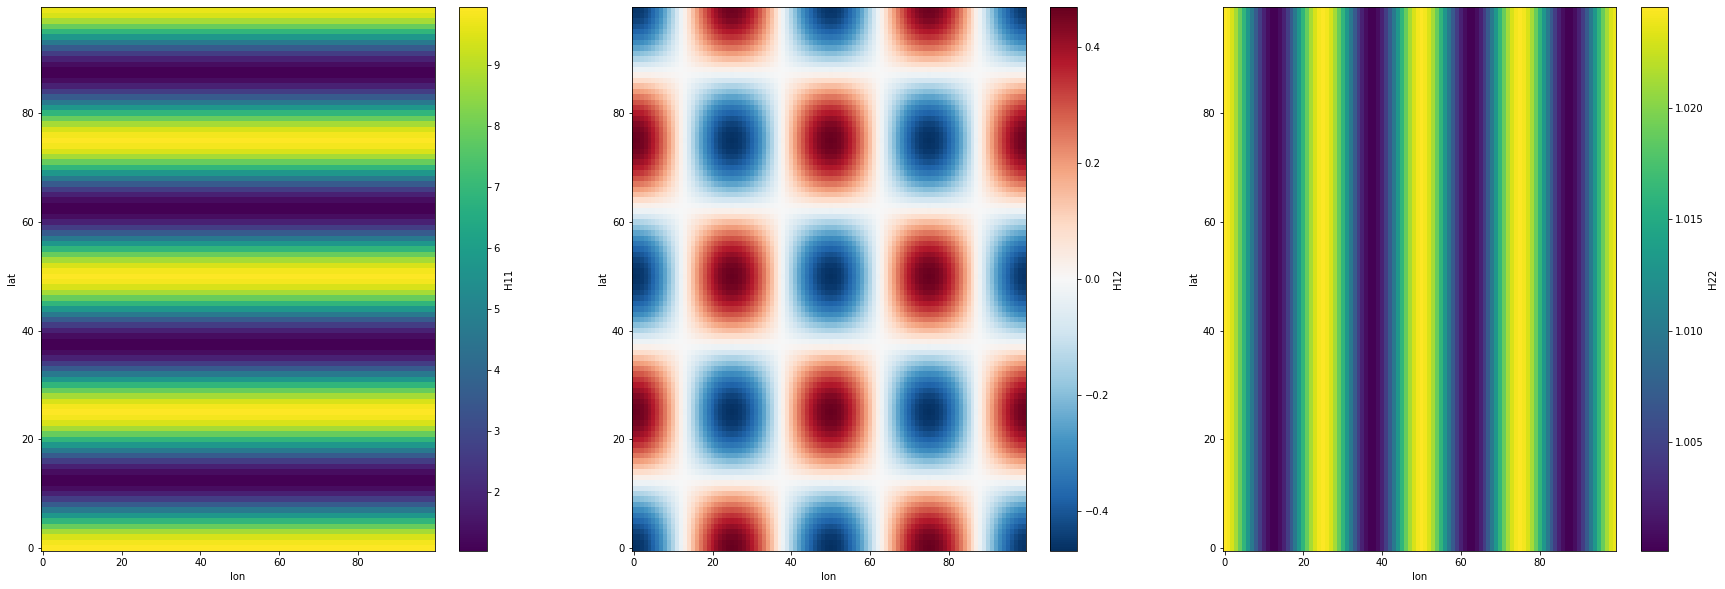

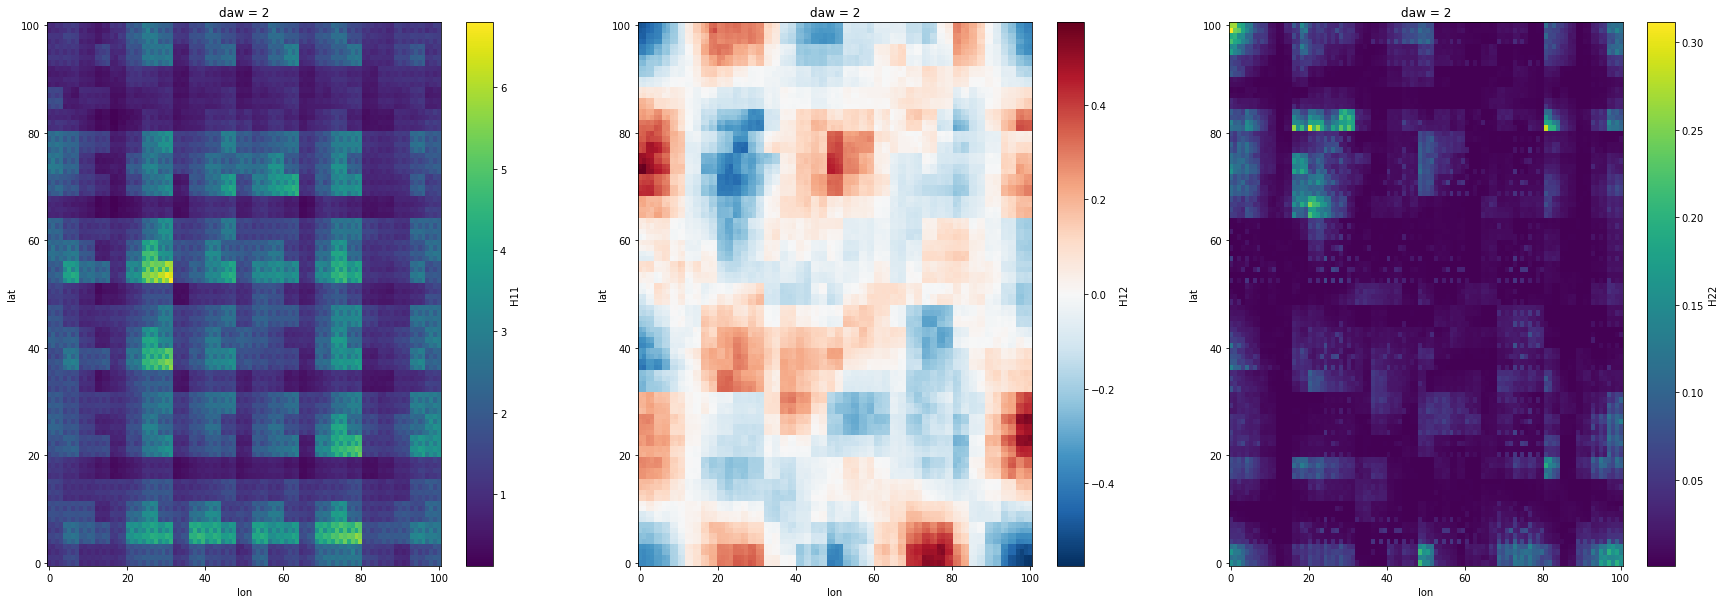

In [98]:
plt.figure(figsize=(30,10))
plt.subplot(131)
data_baseline.H11.plot()
plt.subplot(132)
data_baseline.H12.plot()
plt.subplot(133)
data_baseline.H22.plot()
plt.figure(figsize=(30,10))
plt.subplot(131)
data_4dvarnet.H11.plot()
plt.subplot(132)
data_4dvarnet.H12.plot()
plt.subplot(133)
data_4dvarnet.H22.plot()
plt.show()

## 2. Compute RMSE-based scores

In [99]:
rmse_t_pred_baseline, rmse_xy_pred_baseline, nrmse_pred_baseline, nrmse_std_pred_baseline = rmse_based_scores(data_baseline,'pred')
rmse_t_pred_4dvarnet, rmse_xy_pred_4dvarnet, nrmse_pred_4dvarnet, nrmse_std_pred_4dvarnet = rmse_based_scores(data_4dvarnet,'pred')

## 3. Compute spectral scores

[##########                              ] | 26% Completed |  0.1s

/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  0.4s
[#########                               ] | 24% Completed |  0.1s

/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  0.4s
[###########                             ] | 28% Completed |  0.1s

/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  0.4s
[########                                ] | 21% Completed |  0.1s

/linkhome/rech/genimt01/uba22to/.conda/envs/4dvarnet/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  0.4s


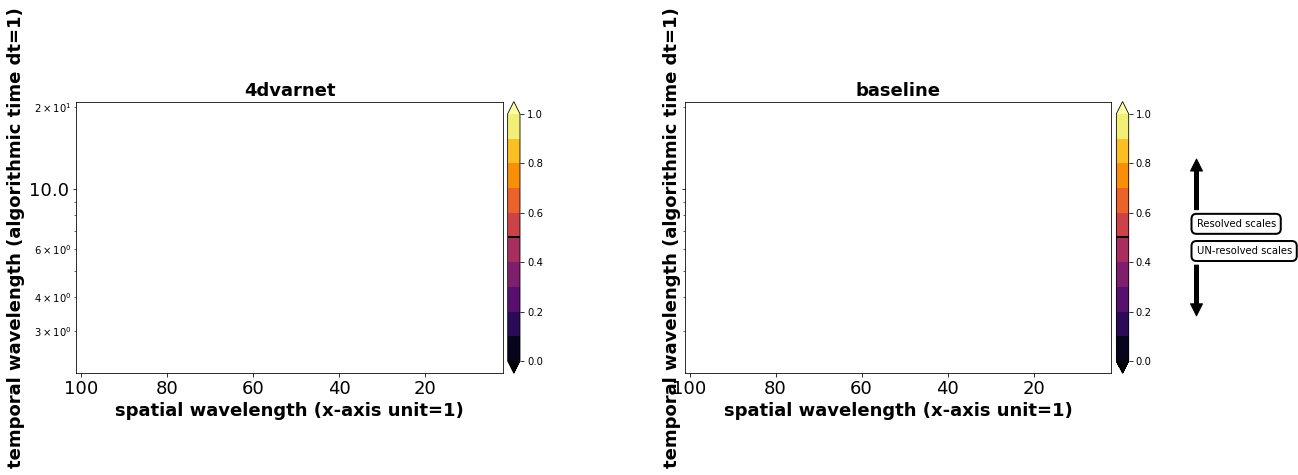

In [100]:
%matplotlib inline  

ds_psd_pred_baseline, lambda_x_pred_baseline, lambda_t_pred_baseline = psd_based_scores(data_baseline,'pred',dx=1,dt=1)
ds_psd_pred_4dvarnet, lambda_x_pred_4dvarnet, lambda_t_pred_4dvarnet = psd_based_scores(data_4dvarnet,'pred',dx=1,dt=1)

psd_concat = xr.concat((ds_psd_pred_4dvarnet, ds_psd_pred_baseline), dim='experiment')
psd_concat['experiment'] = ["4dvarnet","baseline"]
plot_psd_score(psd_concat,dx=1,dt=1)

## 4. Export RMSE and spectral scores

In [101]:
tab_score = pd.DataFrame(dict(name=['4dVarnet',"baseline"],
                  mu_RMSE=[nrmse_pred_4dvarnet,nrmse_pred_baseline],
                  std_RMSE=[nrmse_std_pred_4dvarnet,nrmse_std_pred_baseline],
                  lambda_x_degree=[lambda_x_pred_4dvarnet,lambda_x_pred_baseline],
                  lambda_t_days=[lambda_t_pred_4dvarnet,lambda_t_pred_baseline],
                  Notes = ['4dvarnet','baseline']))
tab_score

,name,mu_RMSE,std_RMSE,lambda_x_degree,lambda_t_days,Notes
0,4dVarnet,0.25,0.04,32.79,19.08,4dvarnet
1,baseline,0.31,0.04,26.61,17.21,baseline


## 5. Display nRMSE time series on the test period 

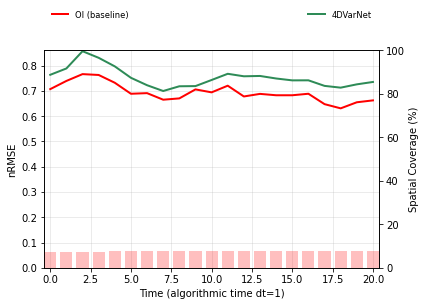

In [102]:
TS(list_data=[data_baseline.gt.values,data_baseline.obs_inp.values,
              data_baseline.pred.values, data_4dvarnet.pred.values],
   labels_data=np.array(['GT','Obs', 'OI (baseline)', '4DVarNet']),
   colors=np.array(['k','','red','seagreen']),
   symbols=np.array(['k','','o','o']),
   lstyle=np.array(['solid','','solid','solid']),lwidth = np.array([2,2,2,2]),
   dt=1,
   gradient=False)

## 6. Display raw and gradient fields

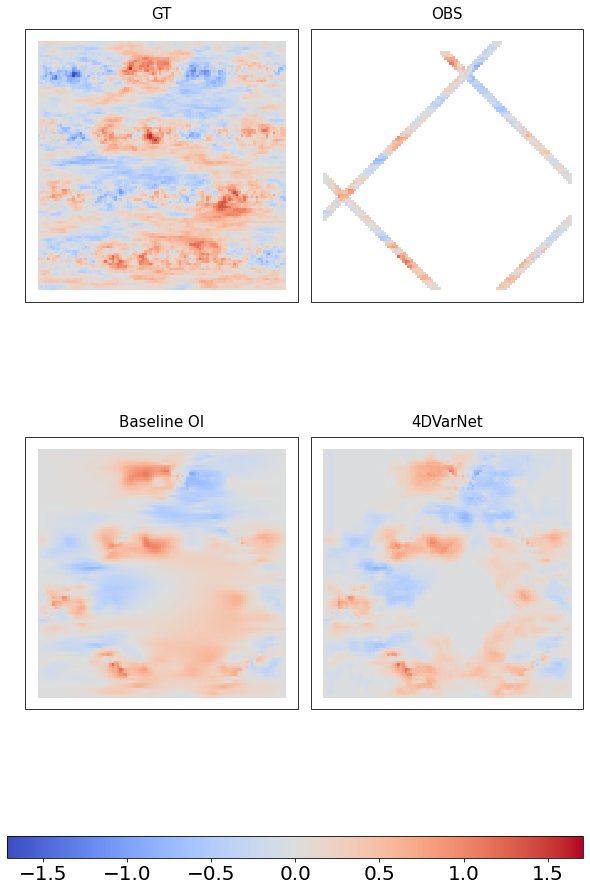

<Figure size 432x288 with 0 Axes>

In [103]:
itime = 20
plot_maps(data_baseline.gt[itime].values,data_baseline.obs_inp[itime].values,
          [data_baseline.pred[itime].values,data_4dvarnet.pred[itime].values],[],
          data_baseline.lon,data_baseline.lat,new_method='4DVarNet',grad=False, 
          orthographic=True,cartopy=False,figsize=(10,15))

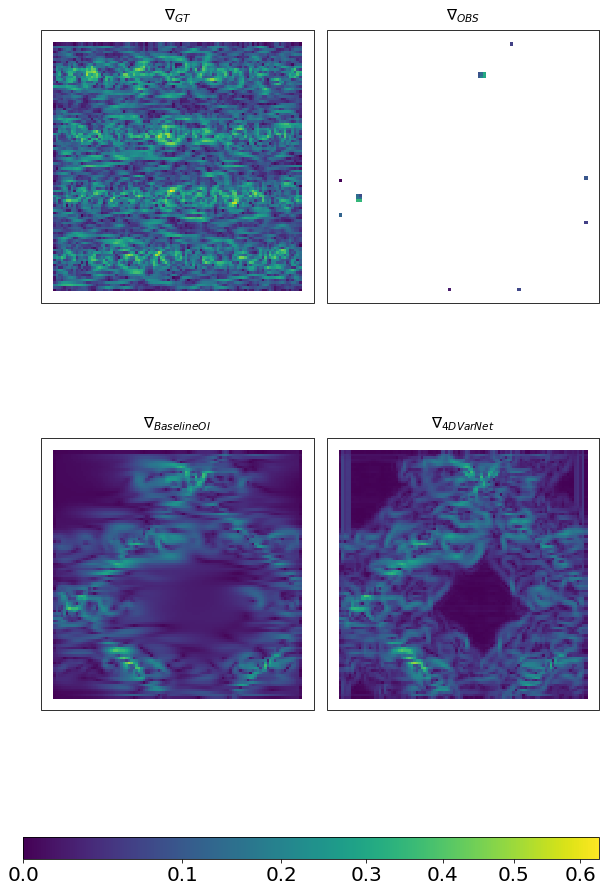

<Figure size 432x288 with 0 Axes>

In [104]:
plot_maps(data_baseline.gt[itime].values,data_baseline.obs_inp[itime].values,
          [data_baseline.pred[itime].values,data_4dvarnet.pred[itime].values],[],
          data_baseline.lon,data_baseline.lat,new_method='4DVarNet',grad=True, 
          orthographic=True,cartopy=False,figsize=(10,15))

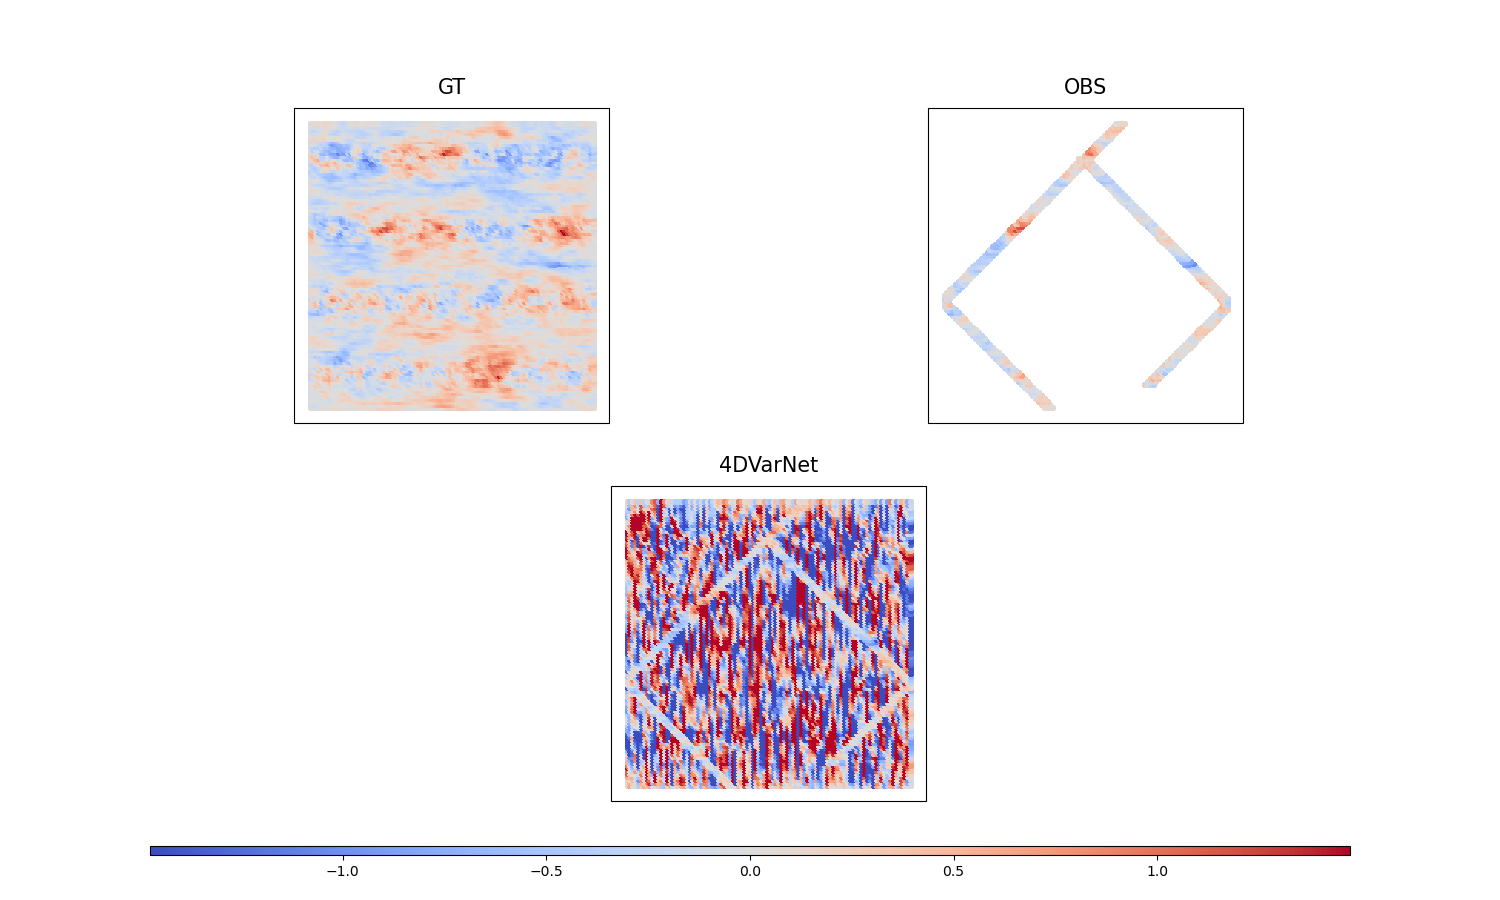

In [105]:
from IPython.display import Image
Image(filename=max(dirs, key=os.path.getctime) + "/simu.png") 

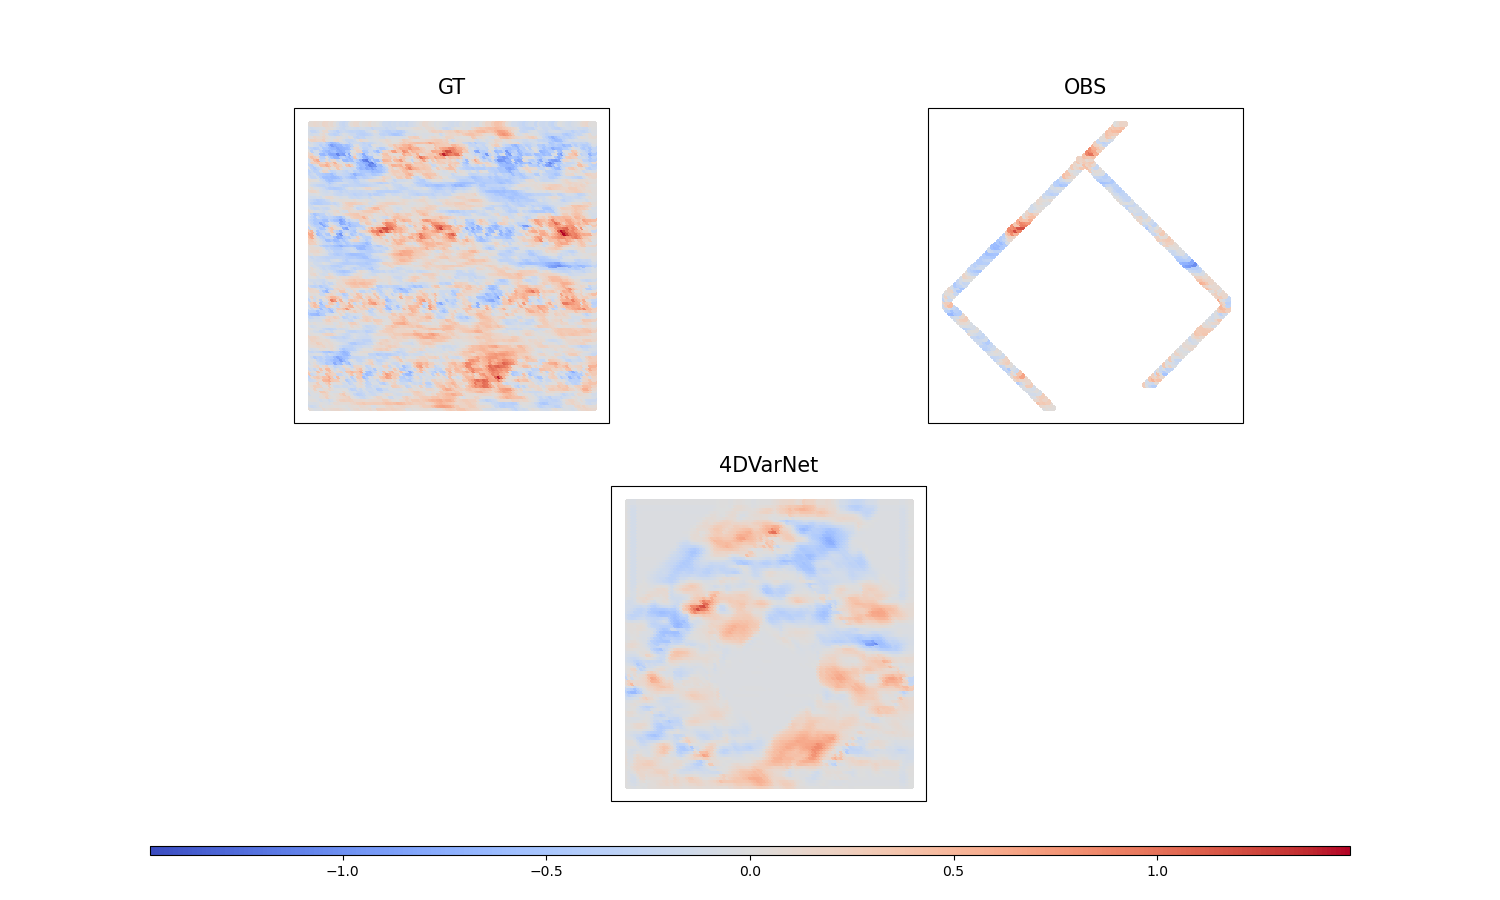

In [106]:
from IPython.display import Image
Image(filename=max(dirs, key=os.path.getctime) + "/maps.png") 